In [6]:
%config IPCompleter.use_jedi=False
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import calendar
import math

from Utils import print_memory_usage

In [7]:
#Setup for plotting
fig_width_pt = 418.25368  # Get this from LaTeX using \showthe\columnwidth, usually 500pt
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (math.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
params = {'backend': 'ps',
          'axes.labelsize': 10, #Was 10
          #'text.fontsize': 10,
          'legend.fontsize': 10, # Was 10
          'xtick.labelsize': 8, #Was 8
          'ytick.labelsize': 8, # was 8
          'text.usetex': True,
          'figure.figsize': fig_size}
matplotlib.rcParams.update(params)
"""
Always Save in "tight" format so there is no surplus of whitespace around the figure.
"""
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1

In [8]:
data_train = pd.read_parquet("Data/Train.parquet")
print_memory_usage(data_train)
data_train.dtypes

The dataframe needs 1.73 GB of memory


tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start station id                    Int64
start station name               category
start station latitude            float64
start station longitude           float64
end station id                      Int64
end station name                 category
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                         category
birth year                          int64
gender                              int64
is_roundtrip                      boolean
haversine distance                float64
speed                             float64
holiday                              bool
business day                         bool
summer                               bool
dtype: object

## Exploratory Analysis

We can confirm again that the classes are very unbalanced.

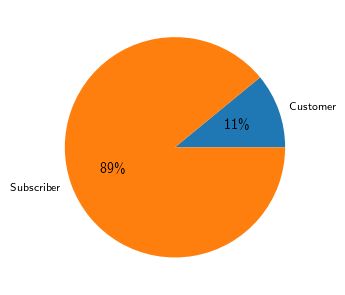

In [10]:
counts = data_train.groupby("usertype").size()
ax = counts.plot.pie(autopct='%1.0f\%%',ylabel="")

### Distribution over month

Let us see how number of customers and subscribers differs per month.

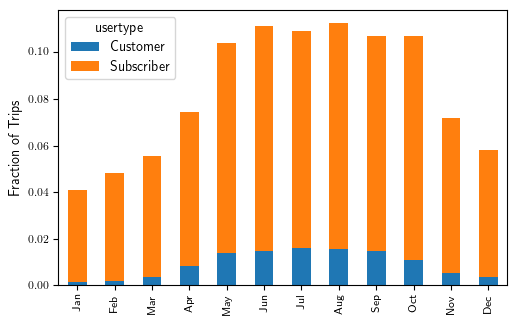

In [11]:
counts = data_train.groupby(by=["usertype",data_train["starttime"].dt.month]).size() / len(data_train)
counts = counts.unstack()
counts = counts.transpose()
ax = counts.plot.bar(stacked=True)
ax.set_ylabel("Fraction of Trips")
ax.set_xticklabels(calendar.month_abbr[1:]);
ax.set_xlabel("");

We see that the amount of Customers varies more strongly with the month than the amount of subscribers.
This is easier to see by looking at the fraction of customers per month.

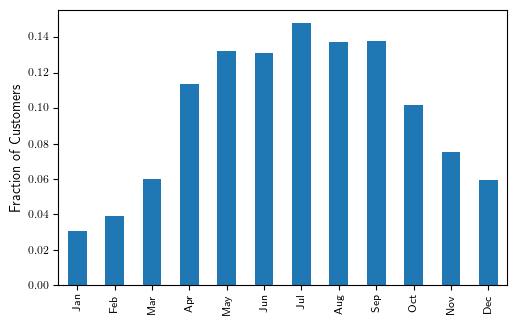

In [16]:
prop = counts.div(counts.sum(axis=1),axis=0)
ax=prop["Customer"].plot.bar(ylabel="Fraction of Customers",xlabel="Month",stacked=True)
ax.set_xticklabels(calendar.month_abbr[1:]);
ax.set_xlabel("");
plt.savefig("Images/CountByMonthCustomers.pdf");

### Holiday vs Business Day

Similarly, there are a lot more customers on holidays than on business day.

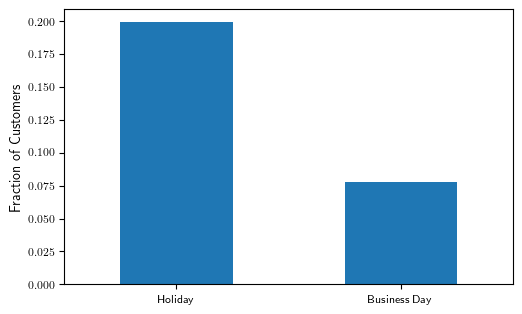

In [20]:
counts = data_train.groupby(by=["usertype","business day"]).size()
counts = counts.unstack().transpose()
counts
prop = counts.div(counts.sum(axis=1),axis=0)
ax = prop["Customer"].plot.bar(ylabel="Fraction of Customers")
ax.set_xticklabels(["Holiday", "Business Day"],rotation=0);
ax.set_xlabel("");
plt.savefig("Images/CountByBusinessCustomers.pdf")

### Speed and Roundtrips

Now, we examine speed, tripduration and distance by usertype.

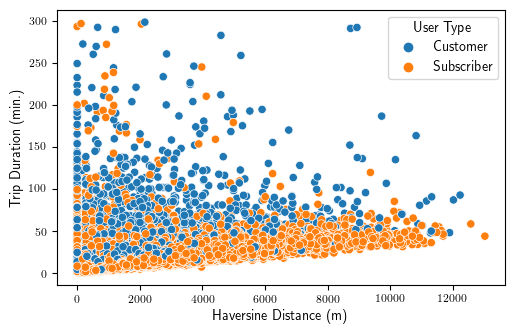

In [28]:
sampled = data_train.sample(n=100000) #We sub-sample the data to a managable amount for a scatter plot
sampled["tripduration"] = sampled["tripduration"] / 60 #Convert to minutes

ax = sns.scatterplot(x="haversine distance",y="tripduration",data=sampled,hue="usertype")
ax.set_xlabel("Haversine Distance (m)");
ax.set_ylabel("Trip Duration (min.)");

plt.legend(title="User Type")
plt.savefig("Images/TimeVsDistance.png",dpi=300)
del sampled

We see that customers tend to make trips that take longer.
They also tend to drive drive slower than subscribers.
We confirm this in the following plot:

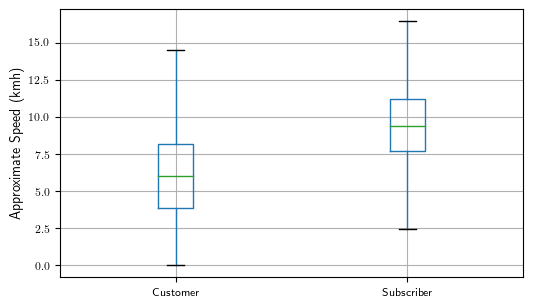

In [27]:
ax = data_train[data_train["is_roundtrip"]==False].boxplot("speed",by="usertype",showfliers=False)
ax.set_title("")
ax.set_ylabel("Approximate Speed (kmh)");
ax.set_xlabel("");
plt.suptitle("");
plt.savefig("Images/SpeedComparison.pdf")

Customers also tend to make slightly more round trips:

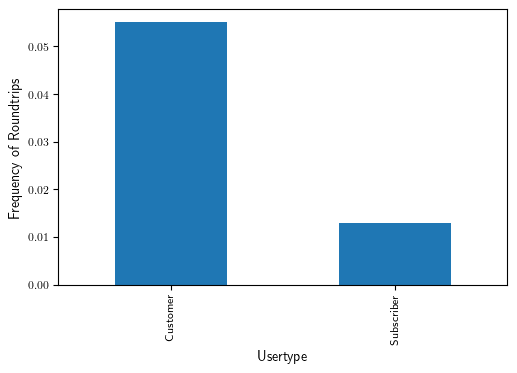

In [23]:
counts = data_train.groupby(["usertype", "is_roundtrip"]).size() / data_train.groupby("usertype").size()
counts=counts.unstack().transpose()
ax = counts.loc[True].plot.bar(ylabel="Frequency of Roundtrips",xlabel="Usertype")

Finally, lets also compare the user types by trip distance:

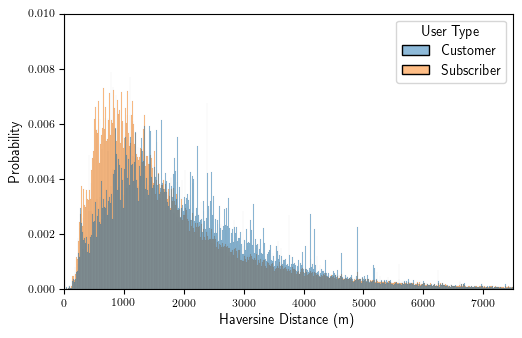

In [25]:
ax = sns.histplot(data = data_train,x = "haversine distance", hue = "usertype", stat="probability", common_norm=False);
ax.set_ylim(0,0.01);
ax.set_xlim(0,7500);
ax.set_xlabel("Haversine Distance (m)");
ax.get_legend().set_title("User Type");
plt.savefig("Images/DistanceComparison.png",dpi=300)

The distances are very comparable, but subscribers cluster more sharply around shorter trips.

### Gender

Now, we compare the user types by gender:

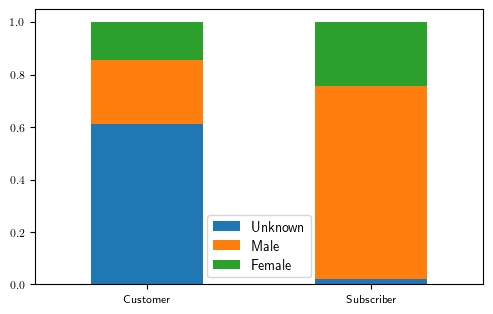

In [44]:
counts = data_train.groupby(["usertype","gender"]).size()
counts = counts/counts.groupby(level=0).sum() #Proportion in each group
counts = counts.unstack()
ax=counts.plot.bar(stacked=True,legend=["unknown","male","female"],xlabel="Usertype")
ax.legend(["Unknown","Male","Female"]);
ax.set_xlabel("");
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0);
plt.savefig("Images/GenderComparison.png",dpi=300)

We see that for most customers, the gender is unknown, while for almost all subscribers the gender is known. This is potentially a very strong predictor for our model. However, for most use cases, this predictor should not be used.
The "gender = unknown" category does not only indicate that the gender is unknown, it indicates that the customer will not provide the gender on registration.
This can only be known after the fact, when it is also known whether the user made the trip as a customer or subscriber.
In other words, this is more a property of the registration process than of the users.

### Time of day of Trips

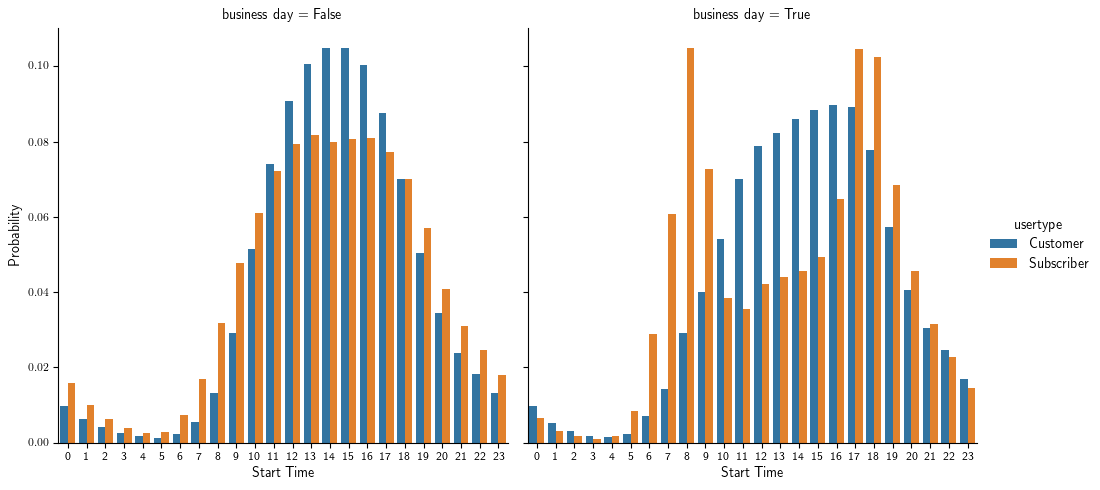

In [34]:
grouped = data_train.groupby(by = [data_train["starttime"].dt.hour,"business day","usertype"]).size()
grouped = grouped / grouped.groupby(level=["business day","usertype"]).sum() #Normalize by dividing by total trips per day
grouped = grouped.reset_index(name="Proportion")
grouped=grouped.rename(columns={"starttime":"Start Time"})
ax = sns.catplot(x="Start Time",y="Proportion",hue="usertype",col="business day",kind="bar",data=grouped);
ax.axes[0,0].set_ylabel("Probability");
plt.savefig("Images/StartTimeByBusiness.png",dpi=300)

We see two interesting facts. The first is that the start times are strongly bimodal for subscribers on a business day. Apparently, most subscribers use the bike on their ways to and from work. This is not the case for customers, whose traffic peaks in the afternoon. Thus, we can use the start time to differentiate these two groups.
The second interesting feature is that the difference between customers and subscribers ist far less pronounced on holidays and weekends. Thus, it might make sense to introduce an interaction variable between "start hour" and "business day" into our models.

### Stations

Let us also check if customers and subscribers tend to commute between different stations.

First, we see that customers tend to cluster more strongly around a few popular stations.

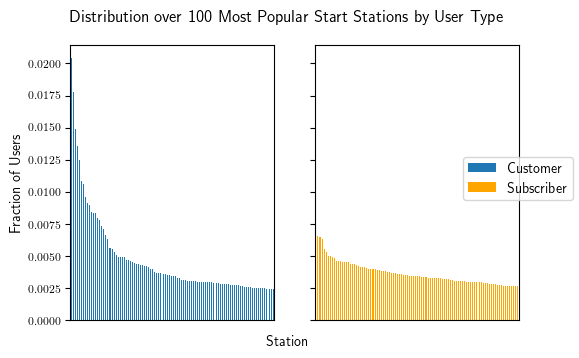

In [39]:
k = 100

grouped = data_train.groupby(["usertype","start station id"]).size()
grouped = grouped / grouped.groupby(level="usertype").sum() #Normalize over start station ids
customers = grouped["Customer"].nlargest(k)
subscribers = grouped["Subscriber"].nlargest(k)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey = True)
plt.suptitle(f"Distribution over {k} Most Popular Start Stations by User Type")

#grouped_plot = grouped.unstack().transpose()
ax = customers.plot.bar(ax=axes[0])
ax.set_ylabel("Fraction of Users")
ax.set_xticks([])
ax.set_xlabel("")
ax = subscribers.plot.bar(ax=axes[1],color="orange");
ax.set_xticks([])
ax.set_xlabel("")
#ax.get_xaxis().set_ticks([]);
#ax.set_ylim(0,0.01);
#ax.set_ylabel("Proportion of Trips from this Station");
fig.legend(["Customer", "Subscriber"], loc=5);
fig.text(0.5, 0.04, 'Station', ha='center');
plt.savefig("Images/StartStationPopularity")

We can look at the most frequent start stations and see that there is very little overlap between customers and subscribers.
Furthermore, customers cluster a bit more around these popular stations.

In [79]:
k = 20
grouped = data_train.groupby("usertype")["start station name"].value_counts()
fraction = grouped["Customer"][0:k].sum() / grouped["Customer"].sum()
popular_customer = grouped["Customer"][0:k]
print(f"The {k} most frequent start stations for customers account for {fraction:.1%} of all customers.")
print(popular_customer)
fraction = grouped["Subscriber"][0:k].sum() / grouped["Subscriber"].sum()
popular_subscriber = grouped["Subscriber"][0:k]
print(f"The {k} most frequent start stations for subscribers account for {fraction:.1%} of all subscribers.")
print(popular_subscriber)
common_stations = popular_customer.index.intersection(popular_subscriber.index)
print(f"The stations they have in common: ")
print(list(common_stations))

The 20 most frequent start stations for customers account for 20.2% of all customers.
start station name
Central Park S & 6 Ave                           31269
Grand Army Plaza & Central Park S                27169
Centre St & Chambers St                          22837
5 Ave & E 88 St                                  20819
12 Ave & W 40 St                                 19159
Central Park West & W 72 St                      16571
5 Ave & E 73 St                                  16237
Pier 40 - Hudson River Park                      14744
West St & Chambers St                            13976
5 Ave & E 78 St                                  13741
Central Park North & Adam Clayton Powell Blvd    12921
Broadway & W 60 St                               12810
Central Park West & W 76 St                      12805
Old Fulton St                                    12250
South End Ave & Liberty St                       11925
Central Park West & W 68 St                      11217
Washington St &

## Birthyear

For some reason, the age of customers is disproportionally often 49 (birth year = 1969).
I expect that this is the easiest item to select in the list on registration, or something similar.
We can also see a small peak at this value for subscribers, but far less extreme.

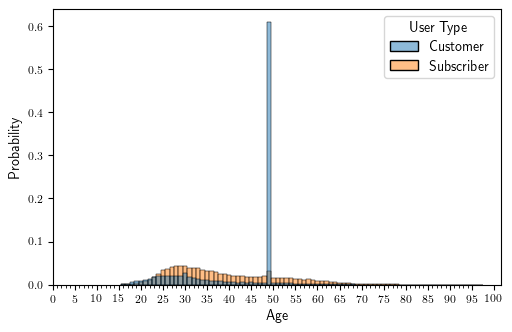

In [42]:
data_train["age"] = 2018 - data_train["birth year"]
ax = sns.histplot(data=data_train,discrete=True,x="age", hue="usertype",common_norm=False,stat="probability");
ax.set_xticks(np.arange(0,96,1),minor=True);
ax.get_legend().set_title("User Type");
ax.set_xlabel("Age");
ax.xaxis.set_major_locator(ticker.MultipleLocator(5));
plt.savefig("Images/AgeDistribution.png",dpi=300)

Apart from this, the age distribution is relatively similar.
Customers do tend to be slightly younger.

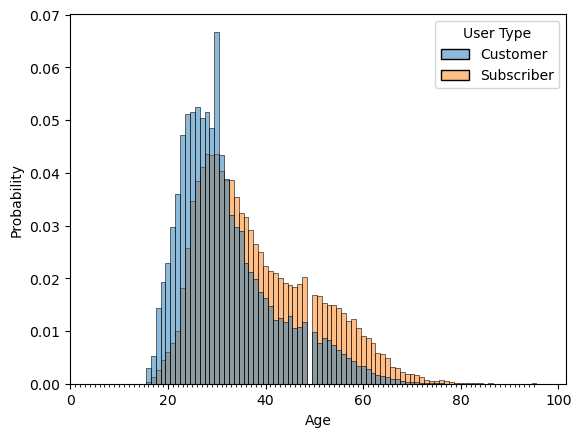

In [95]:
data_filtered = data_train[["usertype","age"]]
data_filtered = data_filtered[data_filtered["age"]!=49]
ax = sns.histplot(data=data_filtered,discrete=True,x="age", hue="usertype",common_norm=False,stat="probability");
ax.set_xticks(np.arange(0,96,1),minor=True);
ax.get_legend().set_title("User Type");
ax.set_xlabel("Age");

Still, it seems like birth year should not be used in the models, because the data is distorted for customers.